In [34]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import numpy as np
from tensorflow.python.keras.preprocessing.image_dataset import image_dataset_from_directory
import matplotlib.pyplot as plt

In [35]:
train_dir = './train'
valid_dir = './valid'

In [36]:
batch_size = 256
img_height = 180
img_width = 180

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 224077 files belonging to 763 classes.


In [37]:
valid_dataset = image_dataset_from_directory(
   valid_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 55670 files belonging to 763 classes.


In [38]:
class_names = train_dataset.class_names
print(class_names)
print(len(class_names))

['class_0', 'class_1', 'class_10', 'class_100', 'class_1000', 'class_1001', 'class_1002', 'class_1005', 'class_1006', 'class_1007', 'class_1008', 'class_1009', 'class_101', 'class_1010', 'class_1012', 'class_1013', 'class_1014', 'class_1015', 'class_1017', 'class_1018', 'class_102', 'class_1021', 'class_1022', 'class_1023', 'class_1024', 'class_1025', 'class_1027', 'class_1028', 'class_1029', 'class_103', 'class_1030', 'class_1031', 'class_1033', 'class_1035', 'class_1037', 'class_1038', 'class_104', 'class_1041', 'class_1042', 'class_1043', 'class_1044', 'class_1045', 'class_1046', 'class_1048', 'class_105', 'class_1050', 'class_1054', 'class_1055', 'class_1056', 'class_1058', 'class_1059', 'class_106', 'class_1060', 'class_1061', 'class_1062', 'class_1063', 'class_1064', 'class_1066', 'class_1068', 'class_1069', 'class_107', 'class_1071', 'class_1072', 'class_1074', 'class_1075', 'class_1076', 'class_1079', 'class_108', 'class_1080', 'class_109', 'class_11', 'class_110', 'class_111',

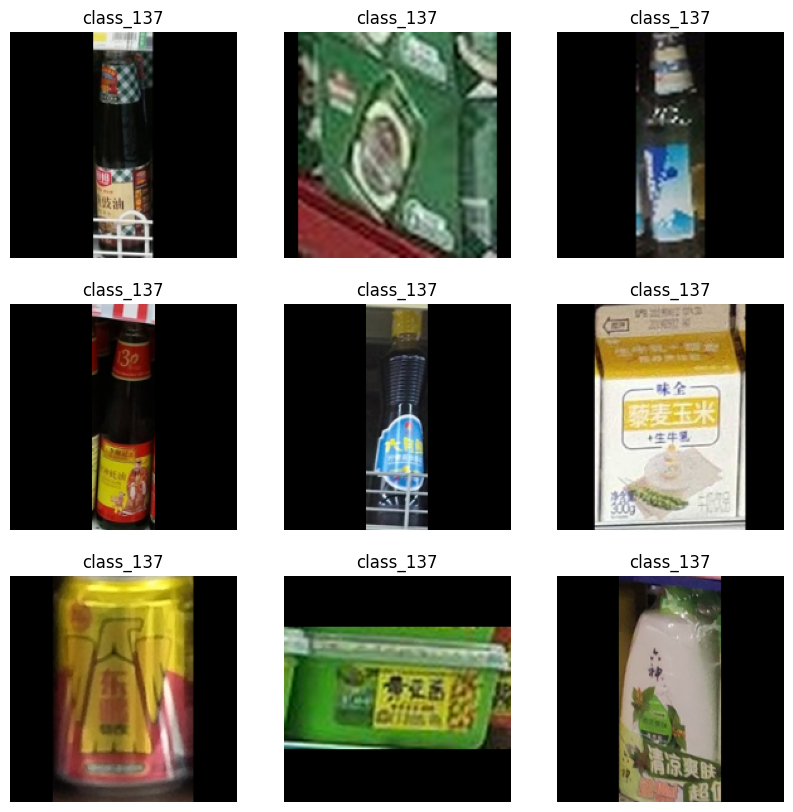

In [39]:
plt.figure(figsize=(10, 10))


for images, labels in train_dataset.take(1):
  for i in range(9):
    image = images[i].numpy().astype("uint8")  
    label_index = tf.argmax(labels).numpy()  
    class_name = class_names[label_index]

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

In [40]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [41]:
base_model = ResNet50(include_top=False, weights='imagenet',input_shape=(180,180,3))
base_model.trainable = False
inputs = tf.keras.Input(shape=(180,180,3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)
print(base_model.output.shape)
x = GlobalAveragePooling2D()(x)
y = Dense(763, activation='softmax')(x) #final layer with softmax activation
model = Model(inputs=inputs, outputs=y, name="ResNet50")
model.summary()

(None, 6, 6, 2048)
Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_3  [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_3 (Tenso [(None, 180, 180, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 763

In [42]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()
model.compile(optimizer='Adam', loss=loss, metrics=metrics)

In [43]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=valid_dataset)

Epoch 1/10
 19/876 [..............................] - ETA: 2:23:20 - loss: 6.5256 - sparse_categorical_accuracy: 0.0413

KeyboardInterrupt: 

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()
model.compile(optimizer='Adam', loss=loss, metrics=metrics)

fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

In [ ]:
image_batch,label_batch = valid_dataset.as_numpy_iterator().next()
print(label_batch)
predictions = model.predict_on_batch(image_batch)

for i in range(0,predictions.shape[0]):
  print(np.argmax(predictions[i]))
  prediction = np.argmax(predictions[i])
  
  if (prediction != label_batch[i]):
    plt.figure(figsize=(10, 10))
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]] + "-" + class_names[prediction])
    plt.show()

In [ ]:
model.save('mymodel.h5')

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import Counter

# Hyperparameters
embedding_dim = 100  # Dimension of word embeddings
context_size = 2      # Size of the context window
learning_rate = 0.001
epochs = 5

# Sample data (replace with your own corpus)
sentences = [
    ["the", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"],
    ["the", "dog", "barked", "at", "the", "cat"],
    ["the", "cat", "sat", "on", "the", "mat"]
]

# Build vocabulary
word_counts = Counter(word for sentence in sentences for word in sentence)
vocabulary = sorted(word_counts)
word_to_ix = {word: i for i, word in enumerate(vocabulary)}
ix_to_word = {i: word for i, word in enumerate(vocabulary)}
vocab_size = len(vocabulary)

['at',
 'barked',
 'brown',
 'cat',
 'dog',
 'fox',
 'jumps',
 'lazy',
 'mat',
 'on',
 'over',
 'quick',
 'sat',
 'the']